In [1]:
import numpy as np
from scipy.io import wavfile
from python_speech_features import sigproc
import matplotlib.pyplot as plt

In [2]:
def buffer(X, n, p=0):
    '''
    Parameters:
    x: ndarray, Signal array, input a long vector as raw speech wav
    n: int, frame length
    p: int, Number of values to overlap
    -----------
    Returns:
    result : (n,m) ndarray, Buffer array created from X
    '''
    n = int(sigproc.round_half_up(n))
    p = int(sigproc.round_half_up(p))
    
    d = n - p
    #print(d)
    m = len(X)//d
    c = n//d
    #print(c)
    if m * d != len(X):
        m = m + 1

    Xn = np.zeros(d*m)
    Xn[:len(X)] = X
    Xn = np.reshape(Xn,(m,d))
    Xn_out = Xn
    for i in range(c-1):
        Xne = np.concatenate((Xn,np.zeros((i+1,d))))
        Xn_out = np.concatenate((Xn_out, Xne[i+1:,:]),axis=1)
        
    if n-d*c>0:
        Xne = np.concatenate((Xn, np.zeros((c,d))))
        Xn_out = np.concatenate((Xn_out,Xne[c:,:n-p*c]),axis=1)

    return np.transpose(Xn_out)

(47104,)


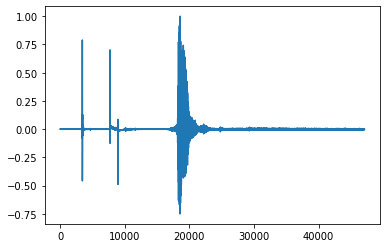

In [21]:
sampling_rate, audio_signal = wavfile.read("output.wav")
print(audio_signal.shape)


winlen= 0.025
signal = audio_signal
signal = sigproc.preemphasis(signal, coeff=0.97)
signal = signal / abs(max(signal))
frames = buffer(signal, winlen*sampling_rate)
plt.plot(signal)

In [22]:
def statBehave(signal,samples=1600,winlen= 0.025,winstep = 0.01):
    
    framedsig = buffer(signal, winlen*sampling_rate)
    numOfFrames=len(framedsig)
    
    first_samples = signal[:samples]
    mean = np.mean(first_samples)
    std = np.std(first_samples)
    
    indexes = np.array([]) #frames to keep
    
    for i in range(numOfFrames):
        d = (abs(framedsig[i,:]- mean))/std
        d[d<3] = 0 #unvoiced
        d[d>3] = 1 #voiced

        ones = np.count_nonzero(d==1)
        zeros = np.count_nonzero(d==0)
        
        if(ones > zeros): 
            if(len(indexes) == 0):
                indexes = [i]
            else:
                indexes= np.append(indexes,i)

    return indexes

[  2  14  17  36  38  39  40  54  55  56  58  64  66  70  71  78  80  89
 104 126 138 142 145 146 149 156 157 162 166 167 169 170 171 172 174 175
 178 183 187 202 204 206 208 211 220 224 226 232 233 238 244 252 253 254
 257 264 265 268 273 274 278 279 284 285 291 294 295 298 300 301 302 305
 307 309 311 313 314 315 321 324 325 334 346 347 353 355 356 359 360 365
 367 377 382 386 387 389 395]


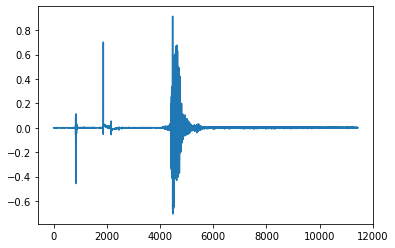

In [23]:
stat_index = statBehave(signal,samples = 1600)
plt.plot(frames[stat_index].flatten('F'))

In [ ]:
def shortTermEnergy(signal, samples=1600,winlen= 0.025,winstep = 0.01):
    
    framedsig = buffer(signal, winlen*sampling_rate)
    numOfFrames=len(framedsig)
    sizeOfFrame= x = frames.shape[1]

    ste = np.zeros(numOfFrames)
    ste_wave = np.zeros(len(signal))
    l=0
    for i in range(numOfFrames):
        ste[i] = sum(np.power(framedsig[i,:],2))
        l = np. count_nonzero(ste_wave)
        ste_wave[l : l + sizeOfFrame] = ste[i]
        
    plt.plot(ste)
    
    energy_max = np.max(ste)
    energy_min = np.min(ste)

    T1 = energy_min*(1+2*(np.log10(energy_max/energy_min)))
    
    arr = ste[ste>T1]
    
    SL = np.sum(arr)/len(arr) #averagee above T1
    
    T2 = T1 + 0.25*(SL-T1)
    indexes = np.array([])
    
    ps =np.array([])
    pe =np.array([])
    
    for i in range(numOfFrames-1):
        if ((ste[i]>T1) and (ste[i+1]>T2)):
            if(len(ps)==1):
                print("ps",i)
                ps = [i]
            else:
                ps = np.append(ps,[i])
        if ((ste[i]<T2) and (ste[i+1]<T1)):
            print("pe",i+1)
            if(len(pe)==1):
                pe = [i+1]
            else:
                pe = np.append(pe,[i+1],axis=0)
    return ps,pe
        

In [16]:
def zerocross(signal, samples=1600,winlen= 0.025,winstep = 0.01):
    
    framedsig = buffer(signal, winlen*sampling_rate)
    numOfFrames=len(framedsig)
    sizeOfFrame= x = frames.shape[1]
    
    ZCR=np.zeros(numOfFrames)
    
    for i in range(numOfFrames):
        f = frames[i,:]
        f2 = np.zeros(sizeOfFrame)
        f2[1:]= f[: -1]
        ZCR[i] = 1/(2*len(f))*sum(abs(np.sign(f)-np.sign(f2)))
    ZCR = ZCR/max(ZCR)
#     print(ZCR)
    
    zcr_wave = np.zeros(len(signal))
    for j in range(len(ZCR)):
        l = np. count_nonzero(zcr_wave)
        zcr_wave[l : l + sizeOfFrame] = ZCR[j];
    plt.plot(zcr_wave)

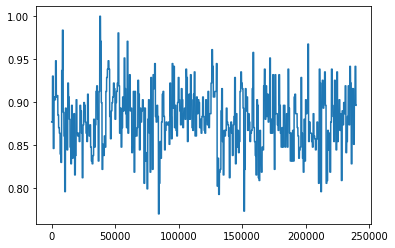

In [17]:
zerocross(signal)

In [ ]:
def getPoints(frames,indexes):
    new_frames = frames
    new_frames[indexes] = np.max(frames[indexes])
    voiced_frames = frames[frames == 1]
    
    return new_frames,voiced_frames    

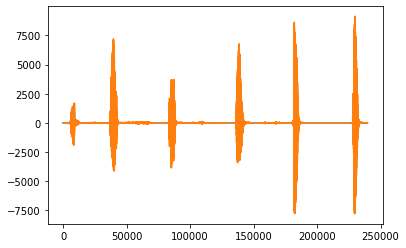

In [24]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, 'VAD/')
from vad import VoiceActivityDetector

v = VoiceActivityDetector('output.wav')
v.plot_detected_speech_regions()

In [34]:
import trimmer as tr

sampling_rate, audio_signal = wavfile.read("test_1.wav")
tr.split_multiple_recordings_file('test.wav')

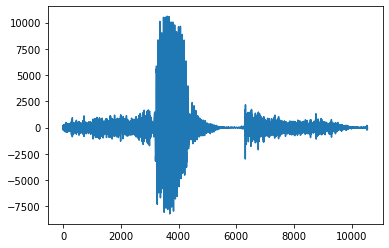

In [35]:
plt.plot(audio_signal)

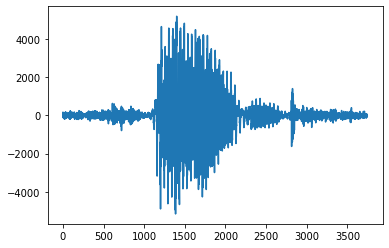

In [36]:
sampling_rate, audio_signal = wavfile.read("../free-digit-recordings/6/george/6_george_1.wav")
plt.plot(audio_signal)